# 自己相関法により基本周波数を推定する
パワー最大となるフレームに対して推定を行うので、系列ではない

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile

In [2]:
IN_WAVE_FILE = "in.wav"  # 分析対象の音声

FRAME_LENGTH = 1024  # フレーム長 (FFTサイズ)
HOP_LENGTH = 80  # フレームのシフト長
FFT_LENGTH = FRAME_LENGTH

MAX_Fo = 200  # 分析における基本周波数の最大値 (Hz)
MIN_Fo = 60  # 分析における基本周波数の最小値 (Hz)

In [3]:
# 音声のロード
fs, data = wavfile.read(IN_WAVE_FILE)
data = data.astype(np.float64)

In [4]:
# フレーム化
frames = librosa.util.frame(data, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T

# パワーが最大のフレーム位置を取得
max_ind = np.argmax(np.sum(frames * frames, axis=1))

# パワーが最大となるフレームを取り出す
pow_max_frame = frames[max_ind, :]

## 自己相関法に基づく基本周波数の推定

In [5]:
# 窓掛け
window = scipy.signal.blackman(FFT_LENGTH)
windowed_frame = pow_max_frame * window

# 自己相関関数の計算
autocorr = scipy.signal.correlate(windowed_frame, windowed_frame)
autocorr /= np.max(autocorr)  # 正規化

# 「右半分」を取得
autocorr = autocorr[int(len(autocorr) / 2) :]

# 自己相関関数の極大点を与えるインデックスを取得（ピーク位置）
relmax_index = scipy.signal.argrelmax(autocorr)[0]

# 各ピーク位置における自己相関関数の値のうち、
# 最大値を与えるときのピーク位置を計算
peak_index = np.argmax(autocorr[relmax_index])

# ピーク位置を基本周期に変換
period = relmax_index[peak_index] / fs

# 基本周波数を計算
fo = 1.0 / period
print(f"Fundamental Frequency = {fo:.2f} Hz")

Fundamental Frequency = 153.85 Hz


## 結果の表示

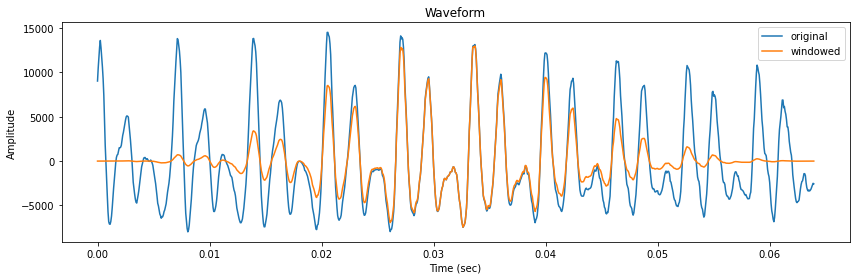

In [6]:
# パワー最大となるフレームの音声波形を表示
fig = plt.figure(figsize=(12, 4))
time = np.arange(len(windowed_frame)) / fs
plt.plot(time, pow_max_frame, label="original")
plt.plot(time, windowed_frame, label="windowed")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.legend()
plt.tight_layout()
plt.show()

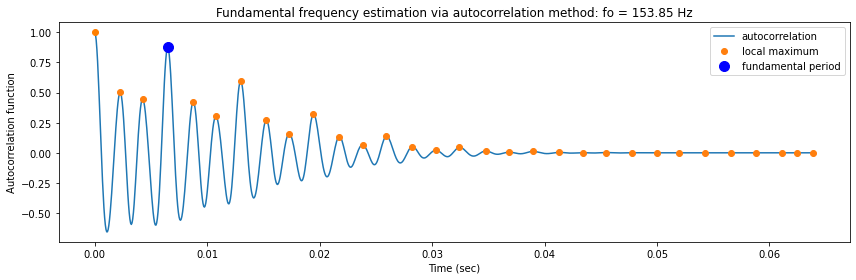

In [7]:
# 自己相関関数と極大値を表示
fig = plt.figure(figsize=(12, 4))
plt.plot(time, autocorr, label="autocorrelation")
plt.plot(
    time[relmax_index],
    autocorr[relmax_index],
    marker="o",
    linestyle="",
    label="local maximum",
)
plt.plot([0], autocorr[0], marker="o", linestyle="", color="#ff7f00")
plt.plot(
    time[relmax_index[peak_index]],
    autocorr[relmax_index[peak_index]],
    marker="o",
    markersize="10",
    linestyle="",
    color="blue",
    label="fundamental period",
)
plt.xlabel("Time (sec)")
plt.ylabel("Autocorrelation function")
plt.title(
    "Fundamental frequency estimation " f"via autocorrelation method: fo = {fo:.2f} Hz"
)
plt.tight_layout()
plt.legend()

plt.show()